In [18]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf

# import datetime and get today's date
import datetime as dt
current_date = dt.datetime.now()

In [19]:
scrip = ['DELHIVERY.NS']
# ['NG=F']
# ['TATAMOTORS.NS']
# ['ICICIBANK.NS']
# ['SI=F']
# ['NIFTYBEES.NS']
# ['CPSEETF.NS']
# ['BANKNIFTY.NS']

In [20]:
Df = yf.download(scrip,'2004-01-01',current_date)
# Df = Df[['Close']]
Df=Df.dropna()
print(Df.info())
Df

[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 523 entries, 2022-05-24 to 2024-07-05
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       523 non-null    float64
 1   High       523 non-null    float64
 2   Low        523 non-null    float64
 3   Close      523 non-null    float64
 4   Adj Close  523 non-null    float64
 5   Volume     523 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 28.6 KB
None


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-05-24,495.200012,568.900024,467.500000,536.349976,536.349976,14210358
2022-05-25,543.799988,544.000000,500.299988,510.700012,510.700012,3810345
2022-05-26,508.000000,518.799988,495.000000,499.799988,499.799988,913963
2022-05-27,505.500000,547.299988,505.100006,541.549988,541.549988,1894346
2022-05-30,535.500000,541.549988,511.750000,521.250000,521.250000,898144
...,...,...,...,...,...,...
2024-07-01,400.149994,403.000000,398.049988,399.850006,399.850006,1134672
2024-07-02,401.000000,401.850006,396.100006,398.049988,398.049988,1188718
2024-07-03,401.000000,401.000000,396.850006,399.399994,399.399994,1147716


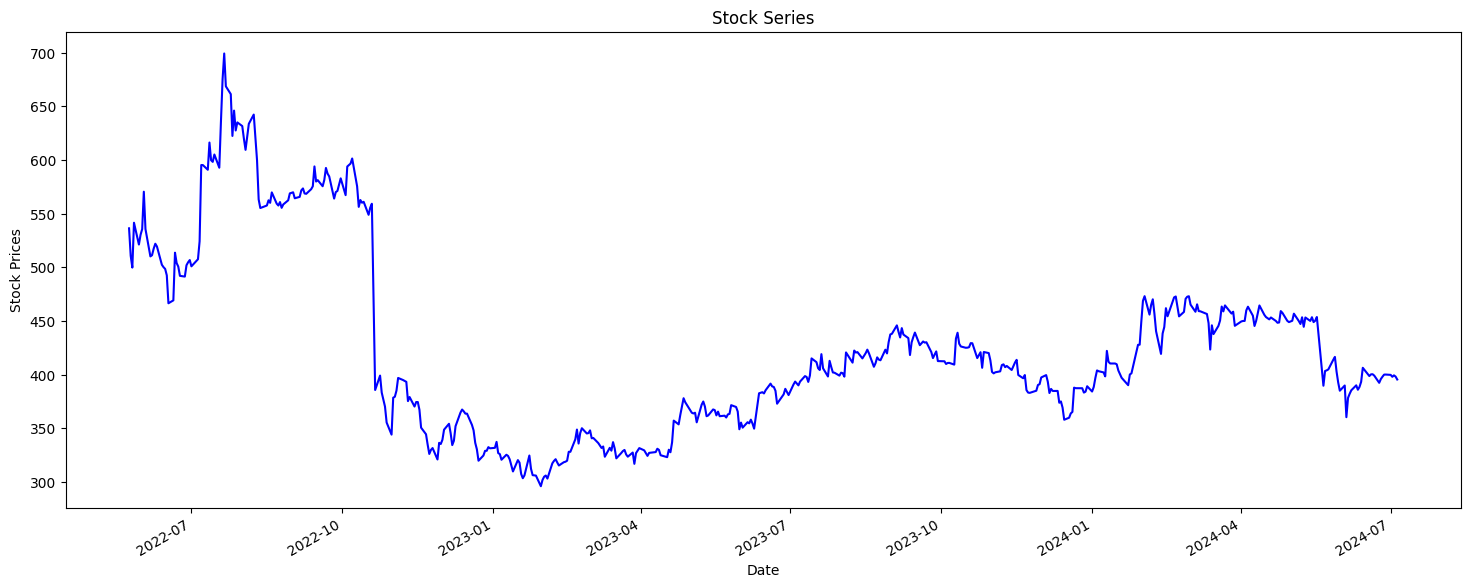

In [21]:
Df['Adj Close'].plot(figsize=(18, 7),color='b')
plt.ylabel("Stock Prices")
plt.title("Stock Series")
plt.show()

In [22]:
# Define explanatory variables
Df['S_3'] = Df['Adj Close'].rolling(window=3).mean()
Df['S_9'] = Df['Adj Close'].rolling(window=11).mean()
Df['vwap'] = ((Df['Volume']*Df['Adj Close'])/Df['Volume']).rolling(window=10).mean()
Df['next_day_price'] = Df['Adj Close'].shift(-1)

Df = Df.dropna()
x = Df[['S_3', 'S_9' , 'vwap']]

# Define dependent variable
y = Df['next_day_price']

In [23]:
# Split the data into train and test dataset
t = .78
t = int(t*len(Df))

# Train dataset
x_train = x[:t]
y_train = y[:t]

# Test dataset
x_test = x[t:]
y_test = y[t:]

In [24]:
# Create a linear regression model
linear = LinearRegression().fit(x_train, y_train)
print("Linear Regression model")
print("Stock Price (y) = %.3f * 3 Days Moving Average (x1) \
+ %.3f * 9 Days Moving Average (x2) \
+ %.3f * VWAP (x3) \
+ %.3f (constant)" % (linear.coef_[0], linear.coef_[1], linear.coef_[2],linear.intercept_,))

Linear Regression model
Stock Price (y) = 1.187 * 3 Days Moving Average (x1) + -0.073 * 9 Days Moving Average (x2) + -0.132 * VWAP (x3) + 7.467 (constant)


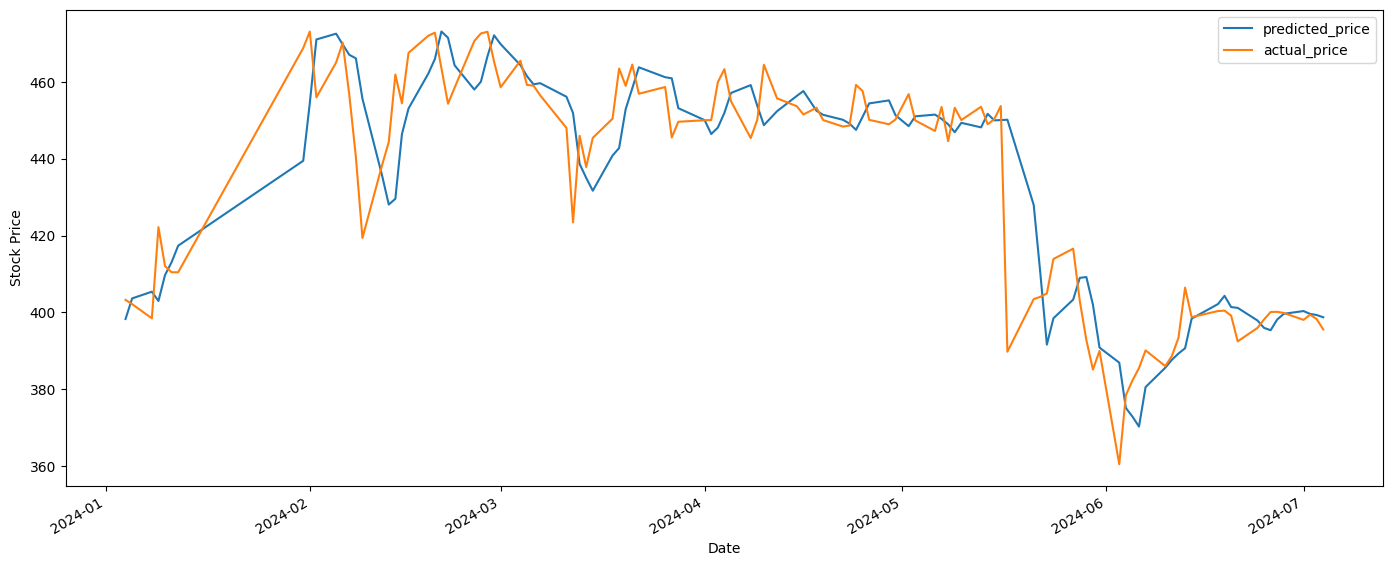

In [25]:
# Predicting the stock prices
predicted_price = linear.predict(x_test)
predicted_price = pd.DataFrame(predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(17, 7))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Stock Price")
plt.show()

In [26]:
# R square
r2_score = linear.score(x[t:], y[t:])*100
float("{0:.2f}".format(r2_score))

82.17

In [27]:
stock = pd.DataFrame()

stock['price'] = Df[t:]['Close']
stock['predicted_price_next_day'] = predicted_price
stock['actual_price_next_day'] = y_test
stock['stock_returns'] = stock['price'].pct_change().shift(-1)

stock['signal'] = np.where(stock.predicted_price_next_day.shift(1) < stock.predicted_price_next_day,1,0)
stock['strategy_returns'] = stock.signal * stock['stock_returns']


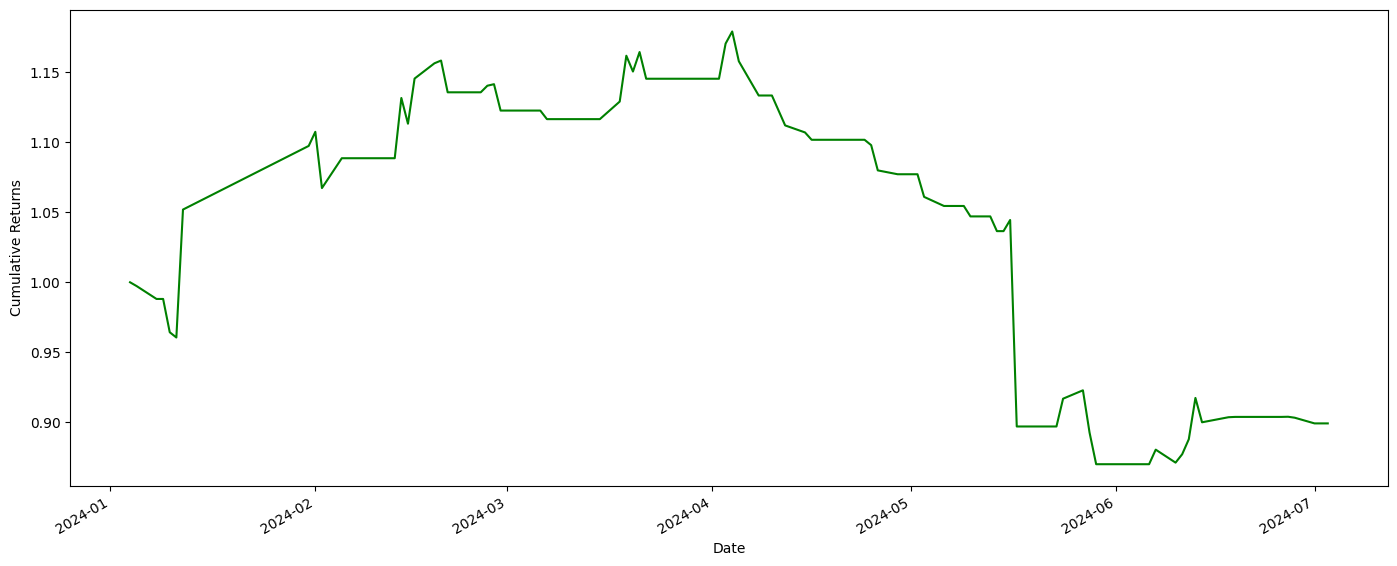

In [28]:

((stock['strategy_returns']+1).cumprod()).plot(figsize=(17,7),color='g')
plt.ylabel('Cumulative Returns')
plt.show()

In [29]:
# Calculate sharpe ratio
sharpe = stock['strategy_returns'].mean()/stock['strategy_returns'].std()*(252**0.5)
'Sharpe Ratio %.2f' % (sharpe)

'Sharpe Ratio -0.59'

In [30]:

# Get the data
data = yf.download(scrip, '2004-01-01', current_date)
data['S_3'] = data['Adj Close'].rolling(window=3).mean()
data['S_9'] = data['Adj Close'].rolling(window=11).mean()
data['vwap'] = ((data['Volume']*data['Adj Close'])/data['Volume']).rolling(window=22).mean()
data = data.dropna()

# Forecast the price
data['predicted_buy_price'] = linear.predict(data[['S_3', 'S_9','vwap']])
data['signal'] = np.where(data.predicted_buy_price.shift(1) < data.predicted_buy_price,"Buy","Sell")

# Print the forecast
data.tail(20)
#  (1)[['signal','predicted_buy_price']].T

[*********************100%%**********************]  1 of 1 completed
<ipython-input-30-9f01eb8b63b3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['predicted_buy_price'] = linear.predict(data[['S_3', 'S_9','vwap']])
<ipython-input-30-9f01eb8b63b3>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['signal'] = np.where(data.predicted_buy_price.shift(1) < data.predicted_buy_price,"Buy","Sell")


,Open,High,Low,Close,Adj Close,Volume,S_3,S_9,vwap,predicted_buy_price,signal
Date,,,,,,,,,,,
2024-06-07,383.100006,389.000000,382.500000,385.500000,385.500000,1242470,382.049998,392.081820,414.465909,377.410612,Buy
2024-06-10,390.549988,396.700012,386.149994,390.100006,390.100006,1240148,385.950002,390.731820,411.584091,382.521637,Buy
2024-06-11,394.899994,394.899994,384.200012,386.000000,386.000000,1291365,387.200002,388.195457,408.920455,384.544466,Buy
2024-06-12,390.000000,393.950012,386.149994,388.649994,388.649994,1064641,388.250000,385.654547,405.981818,386.366613,Buy
2024-06-13,394.000000,395.500000,387.500000,393.399994,393.399994,2220747,389.349996,384.781819,403.404545,388.078013,Buy
2024-06-14,394.000000,411.000000,393.049988,406.450012,406.450012,4059146,396.166667,386.022730,401.263637,396.363839,Buy
2024-06-18,406.899994,409.399994,396.149994,398.750000,398.750000,2235588,399.533335,387.263639,398.979546,400.572629,Buy
2024-06-19,400.000000,406.450012,394.000000,400.350006,400.350006,2535998,401.850006,388.209093,396.709093,403.554652,Buy
2024-06-20,404.850006,406.850006,398.250000,400.450012,400.450012,3358655,399.850006,391.845456,394.286366,401.234732,Sell
